In [3]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.8 MB/s eta 0:00:00


In [4]:
import osmnx

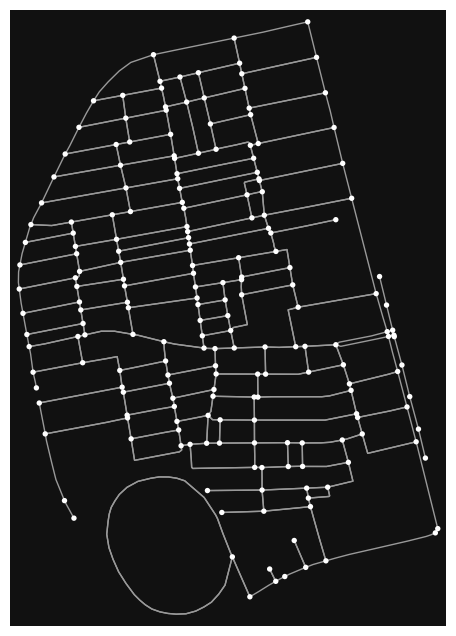

In [7]:
PLACE_NAME = "Mirpur, Dhaka, Bangladesh"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

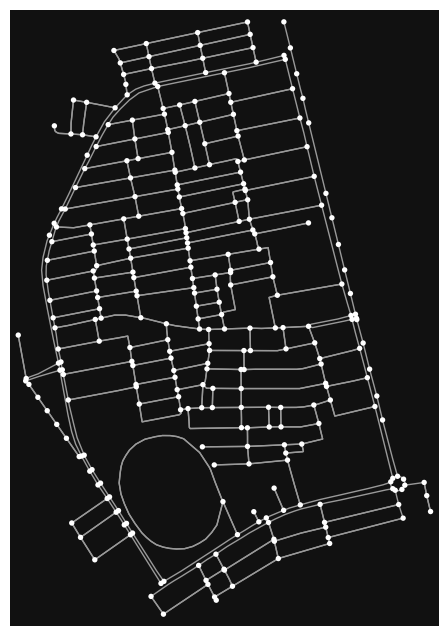

In [8]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

In [9]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid            name      highway  oneway  \
u         v          key                                                   
264877445 3731774499 0     24402401   Mirpur 2 Road     tertiary   False   
264877808 6122934819 0    648400846             NaN  residential   False   
          3812130105 0    650559291             NaN     tertiary    True   
264877813 4454391358 0    448429682             NaN  residential   False   
          6087186112 0    650559290  Milk Vita Road     tertiary    True   

                         reversed   length lanes maxspeed  \
u         v          key                                    
264877445 3731774499 0      False   48.745   NaN      NaN   
264877808 6122934819 0       True   30.746   NaN      NaN   
          3812130105 0      False   78.345     2       30   
264877813 4454391358 0       True  106.587   NaN      NaN   
          6087186112 0      False   45.798     2       30   

                                                                   geometry  \
u         v          key                                                      
264877445 3731774499 0    LINESTRING (90.36315 23.80481, 90.36343 23.80445)   
264877808 6122934819 0    LINESTRING (90.36193 23.81411, 90.36164 23.81415)   
          3812130105 0    LINESTRING (90.36193 23.81411, 90.36212 23.814...   
264877813 4454391358 0    LINESTRING (90.36084 23.81121, 90.36187 23.81140)   
          6087186112 0    LINESTRING (90.36084 23.81121, 90.36088 23.810...   

                         junction service width access  
u         v          key                                
264877445 3731774499 0        NaN     NaN   NaN    NaN  
264877808 6122934819 0        NaN     NaN   NaN    NaN  
          3812130105 0        NaN     NaN   NaN    NaN  
264877813 4454391358 0        NaN     NaN   NaN    NaN  
          6087186112 0        NaN     NaN   NaN    NaN

In [10]:
edges["highway"].value_counts()

residential                     542
tertiary                         84
primary                          52
living_street                    38
unclassified                     20
service                          10
primary_link                      2
[residential, living_street]      2
[residential, unclassified]       2
pedestrian                        2
secondary                         1
Name: highway, dtype: int64

In [11]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph)

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: +proj=utm +zone=46 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 46N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 298,
 'm': 755,
 'k_avg': 5.067114093959732,
 'edge_length_total': 43988.97999999995,
 'edge_length_avg': 58.263549668874106,
 'streets_per_node_avg': 3.087248322147651,
 'streets_per_node_counts': {0: 0, 1: 6, 2: 0, 3: 254, 4: 38},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.020134228187919462,
  2: 0.0,
  3: 0.8523489932885906,
  4: 0.12751677852348994},
 'intersection_count': 292,
 'street_length_total': 25467.331000000013,
 'street_segment_count': 431,
 'street_length_avg': 59.088935034802816,
 'circuity_avg': 1.0425264292166547,
 'self_loop_proportion': 0.002320185614849188}

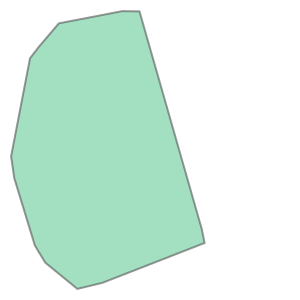

In [13]:
convex_hull = edges.unary_union.convex_hull
convex_hull

In [14]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 298,
 'm': 755,
 'k_avg': 5.067114093959732,
 'edge_length_total': 43988.97999999995,
 'edge_length_avg': 58.263549668874106,
 'streets_per_node_avg': 3.087248322147651,
 'streets_per_node_counts': {0: 0, 1: 6, 2: 0, 3: 254, 4: 38},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.020134228187919462,
  2: 0.0,
  3: 0.8523489932885906,
  4: 0.12751677852348994},
 'intersection_count': 292,
 'street_length_total': 25467.331000000013,
 'street_segment_count': 431,
 'street_length_avg': 59.088935034802816,
 'circuity_avg': 1.0425264292166547,
 'self_loop_proportion': 0.002320185614849188,
 'node_density_km': 346.81871768885003,
 'intersection_density_km': 339.8357904870611,
 'edge_density_km': 51195.30750349146,
 'street_density_km': 29639.419732810413}

In [18]:
origin = (
    osmnx.geocode_to_gdf("Sher-E-Bangla National Cricket Stadium, Mirpur")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("Shaheed Suhrawardi Indoor Stadium")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [19]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

6344100205

In [22]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

4584915147

In [23]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[6344100205,
 3713359146,
 3713290623,
 3713290622,
 3713302769,
 3713300813,
 3713266303,
 3713271155,
 3713271156,
 3713271157,
 3713343695,
 3713343694,
 3853656398,
 6122923915,
 4584915146,
 4584915147]

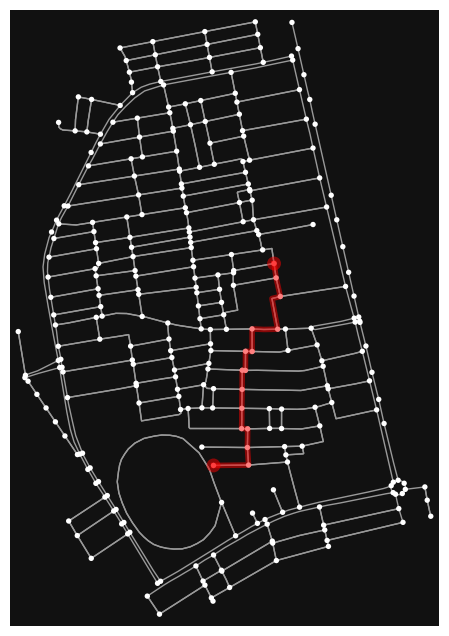

In [24]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

In [25]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
6344100205,2.635405e+06,231484.086065,1,90.364551,23.807468,NaN,POINT (231484.086 2635404.910)
3713359146,2.635406e+06,231562.466511,3,90.365319,23.807490,NaN,POINT (231562.467 2635405.792)
3713290623,2.635445e+06,231559.881340,4,90.365287,23.807843,NaN,POINT (231559.881 2635445.029)
3713290622,2.635487e+06,231560.401975,3,90.365284,23.808220,NaN,POINT (231560.402 2635486.780)
3713302769,2.635487e+06,231546.901846,3,90.365152,23.808223,NaN,POINT (231546.902 2635487.363)
3713300813,2.635533e+06,231547.368133,4,90.365148,23.808633,NaN,POINT (231547.368 2635532.772)
3713266303,2.635575e+06,231548.011459,4,90.365147,23.809015,NaN,POINT (231548.011 2635575.086)
3713271155,2.635618e+06,231548.367012,3,90.365143,23.809400,NaN,POINT (231548.367 2635617.826)
3713271156,2.635618e+06,231555.377563,3,90.365211,23.809399,NaN,POINT (231555.378 2635617.563)


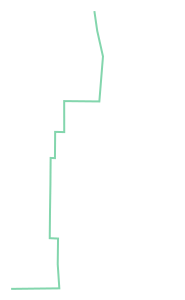

In [26]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

In [27]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (231484.086 2635404.910, 231562.467...","[6344100205, 3713359146, 3713290623, 371329062...",623.979915


In [31]:
buildings = osmnx.geometries_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

<ipython-input-31-78706217fa7e>:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = osmnx.geometries_from_place(


In [29]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.1 MB/s eta 0:00:00


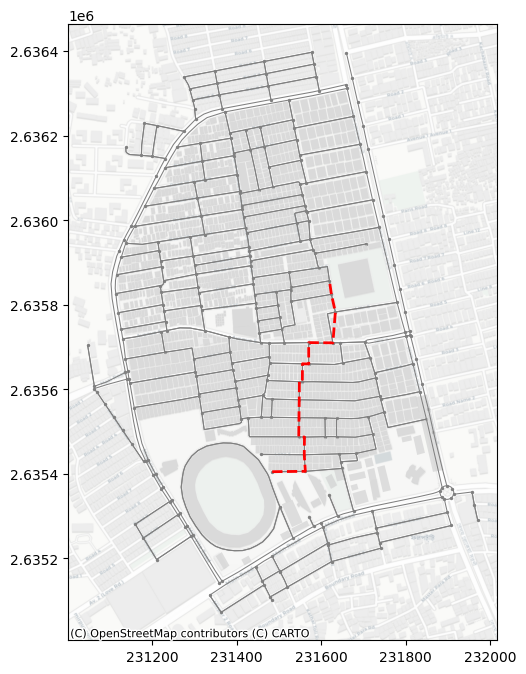

In [32]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [33]:
edges.head()

osmid           name      highway  oneway  \
u          v          key                                                  
264877445  3731774499 0     24402401  Mirpur 2 Road     tertiary   False   
3731774499 264877445  0     24402401  Mirpur 2 Road     tertiary   False   
           3731774500 0    369383730            NaN  residential   False   
264877808  6122934819 0    648400846            NaN  residential   False   
           3812130105 0    650559291            NaN     tertiary    True   

                          reversed   length  \
u          v          key                     
264877445  3731774499 0      False   48.745   
3731774499 264877445  0       True   48.745   
           3731774500 0      False  120.612   
264877808  6122934819 0       True   30.746   
           3812130105 0      False   78.345   

                                                                    geometry  \
u          v          key                                                      
264877445  3731774499 0    LINESTRING (231335.965 2635112.603, 231363.207...   
3731774499 264877445  0    LINESTRING (231363.207 2635072.275, 231335.965...   
           3731774500 0    LINESTRING (231363.207 2635072.275, 231383.651...   
264877808  6122934819 0    LINESTRING (231231.085 2636145.885, 231200.714...   
           3812130105 0    LINESTRING (231231.085 2636145.885, 231250.424...   

                          lanes maxspeed junction service width access  
u          v          key                                               
264877445  3731774499 0     NaN      NaN      NaN     NaN   NaN    NaN  
3731774499 264877445  0     NaN      NaN      NaN     NaN   NaN    NaN  
           3731774500 0     NaN      NaN      NaN     NaN   NaN    NaN  
264877808  6122934819 0     NaN      NaN      NaN     NaN   NaN    NaN  
           3812130105 0       2       30      NaN     NaN   NaN    NaN

In [35]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "maxspeed",
    "reversed",
    "junction",
    "access",
    "service",

]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [36]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

In [54]:
!pip install geopandas fiona shapely

In [57]:
print(edges.head())
print(route_geom.head())
print(nodes.head())
print(buildings.head())


                               osmid           name      highway  oneway  \
u          v          key                                                  
264877445  3731774499 0     24402401  Mirpur 2 Road     tertiary   False   
3731774499 264877445  0     24402401  Mirpur 2 Road     tertiary   False   
           3731774500 0    369383730            nan  residential   False   
264877808  6122934819 0    648400846            nan  residential   False   
           3812130105 0    650559291            nan     tertiary    True   

                          reversed   length  \
u          v          key                     
264877445  3731774499 0      False   48.745   
3731774499 264877445  0       True   48.745   
           3731774500 0      False  120.612   
264877808  6122934819 0       True   30.746   
           3812130105 0      False   78.345   

                                                                    geometry  \
u          v          key                                

In [50]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = "/content/drive/MyDrive/data"

In [61]:
import os
output_gpkg = os.path.abspath("/content/drive/MyDrive/OSM_Mirpur.gpkg")

In [62]:
# Save one layer after another
#output_gpkg ="/content/drive/MyDrive/OSM_Mirpur.gpkg"

edges.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route", driver='GPKG')
nodes.to_file(output_gpkg, layer="nodes", driver='GPKG')
buildings[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings", driver='GPKG')
